# Master Thesis - Simulated Pick and Place Machine - Data Gathering

<img src="simulation.png" width="750">

In [7]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

def convert_to_entry(input_dict):
    return {key: [value] for key, value in input_dict.items()}

def convert_list_df(input_list):
    df = pd.DataFrame(convert_to_entry(input_list[0]))
    for i in range(1,len(input_list)):
        df.loc[i] = convert_to_entry(input_list[i])
    return df


## Connection to Simulation

In [ ]:
client = RemoteAPIClient()


sim = client.require('sim')
simBWF = client.require('simBWF')

sim.setStepping(True)

sim.startSimulation()

camera_1 = sim.getObject('/camera_1/camera')
camera_2 = sim.getObject('/camera_2/camera')
camera_3 = sim.getObject('/camera_3/camera')
camera_4 = sim.getObject('/camera_4/camera')
camera_5 = sim.getObject('/camera_5/camera')
camera_6 = sim.getObject('/camera_6/camera')

camera_1_df = pd.DataFrame()
camera_2_df = pd.DataFrame()
camera_3_df = pd.DataFrame()
camera_4_df = pd.DataFrame()
camera_5_df = pd.DataFrame()
camera_6_df = pd.DataFrame()

conveyor1 = sim.getObject("/genericConveyorTypeA[0]")
conveyor2 = sim.getObject("/genericConveyorTypeA[2]")
conveyor3 = sim.getObject("/genericConveyorTypeA[1]")

conveyor_1_df = pd.DataFrame()
conveyor_2_df = pd.DataFrame()
conveyor_3_df = pd.DataFrame()

detectionWindow_1 = sim.getObject("/genericDetectionWindow[3]")
detection_1_df = pd.DataFrame()


while (t := sim.getSimulationTime()) < 10:
    camera_1_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(camera_1,'customData'))])
    camera_2_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(camera_2,'customData'))])
    camera_3_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(camera_3,'customData'))])
    camera_4_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(camera_4,'customData'))])
    camera_5_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(camera_5,'customData'))])
    camera_6_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(camera_6,'customData'))])


    conveyor_1_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(conveyor1, simBWF.modelTags.CONVEYOR))])
    conveyor_2_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(conveyor2, simBWF.modelTags.CONVEYOR))])
    conveyor_3_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(conveyor3, simBWF.modelTags.CONVEYOR))])

    detection_1_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(detectionWindow_1,'customData'))])

    camera_1_df= pd.concat([camera_1_df,camera_1_data], ignore_index=True)
    camera_2_df= pd.concat([camera_2_df,camera_2_data], ignore_index=True)
    camera_3_df= pd.concat([camera_3_df,camera_3_data], ignore_index=True)
    camera_4_df= pd.concat([camera_4_df,camera_4_data], ignore_index=True)
    camera_5_df= pd.concat([camera_5_df,camera_5_data], ignore_index=True)
    camera_6_df= pd.concat([camera_6_df,camera_6_data], ignore_index=True)


    conveyor_1_df= pd.concat([conveyor_1_df,conveyor_1_data['velocity']], ignore_index=True)
    conveyor_2_df= pd.concat([conveyor_2_df,conveyor_2_data['velocity']], ignore_index=True)
    conveyor_3_df= pd.concat([conveyor_3_df,conveyor_3_data['velocity']], ignore_index=True)

    detection_1_df= pd.concat([detection_1_df,detection_1_data], ignore_index=True)

    sim.step()

sim.stopSimulation()

## Data preparation

In [6]:
camera_1_df.replace(np.nan,0,inplace=True)
camera_2_df.replace(np.nan,0,inplace=True)
camera_3_df.replace(np.nan,0,inplace=True)
camera_4_df.replace(np.nan,0,inplace=True)
camera_5_df.replace(np.nan,0,inplace=True)
camera_6_df.replace(np.nan,0,inplace=True)

conveyor_1_df.replace(np.nan,0,inplace=True)
conveyor_2_df.replace(np.nan,0,inplace=True)
conveyor_3_df.replace(np.nan,0,inplace=True)

detection_1_df.replace(np.nan,0,inplace=True)


## Causal Graph

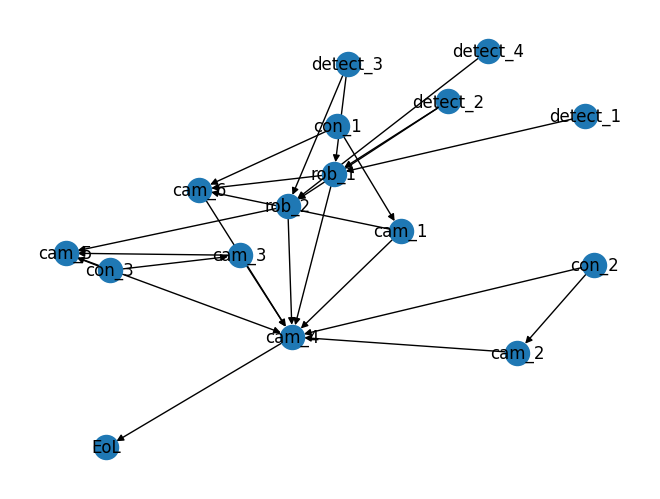

In [19]:
G = nx.DiGraph()

# Sensor - grouped
G.add_node("cam_1")
G.add_node("cam_2")
G.add_node("cam_3")
G.add_node("cam_4")
G.add_node("cam_5")
G.add_node("cam_6")
G.add_node("con_1")
G.add_node("con_2")
G.add_node("con_3")
G.add_node("rob_1")
G.add_node("rob_2")

G.add_node("detect_1")
G.add_node("detect_2")
G.add_node("detect_3")
G.add_node("detect_4")

G.add_node("EoL")

#G.add_edge("A", "B")
G.add_edge("cam_4", "EoL")

# Same conveyor
G.add_edge("cam_1", "cam_6")
G.add_edge("cam_2", "cam_4")
G.add_edge("cam_3", "cam_5")

# End of Line
G.add_edge("cam_1", "cam_4")
G.add_edge("cam_3", "cam_4")
G.add_edge("cam_5", "cam_4")
G.add_edge("cam_6", "cam_4")


# Conveyor affect camera
G.add_edge("con_1", "cam_1")
G.add_edge("con_1", "cam_6")
G.add_edge("con_2", "cam_2")
G.add_edge("con_2", "cam_4")
G.add_edge("con_3", "cam_3")
G.add_edge("con_3", "cam_5")

# Robot
G.add_edge("rob_1", "cam_4")
G.add_edge("rob_1", "cam_6")
G.add_edge("rob_2", "cam_4")
G.add_edge("rob_2", "cam_5")

# Detection or Robot
G.add_edge("detect_1", "rob_1")
G.add_edge("detect_2", "rob_1")
G.add_edge("detect_3", "rob_1")
G.add_edge("detect_2", "rob_2")
G.add_edge("detect_3", "rob_2")
G.add_edge("detect_4", "rob_2")


# Draw the graph
nx.draw(G, with_labels=True)
plt.show()